In [67]:
from data_processing import *
import glob
import math
import pandas as pd
import numpy as np
import scipy
from scipy.signal import find_peaks, peak_prominences, peak_widths
import matplotlib.pyplot as plt
import warnings
from os import path
warnings.filterwarnings("ignore")

In [63]:
columns = pd.read_csv('data/columns.txt', header=None)
columns_list = columns.transpose().values.tolist()[0]

sensors = ['leftJointPosition', 'rightJointPosition', 'leftJointVelocity',
           'rightJointVelocity', 'imuGyroX', 'imuGyroY', 'imuGyroZ', 'imuAccX',
           'imuAccY', 'imuAccZ']

mode_pool = ['L0R0', 'L0R1', 'L1R0', 'L1R1', 'L1R2', 'L2R1', 'L2R2', 'L3R0', 'L3R1']
trial_pool = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data_all = []

data_dir = 'data/'
for mode in mode_pool:
    for trial in trial_pool:
        file_path = data_dir+'log_'+str(mode)+'_'+str(trial)+'.txt'
        if path.exists(file_path) == 1:
            for read_path in glob.glob(file_path):
                data = pd.read_csv(read_path, sep=" ", header=None)
                data = data.iloc[:,0:15]
                data.columns = columns_list
                data = data[sensors]
                data_all.append(data)

In [97]:
left_joint_positions, right_joint_positions = extract_joint_positions(data_all)

labels = []
for i in range(len(data_all)):
    left_x, left_y = label_vectors(left_joint_positions[i])
    right_x, right_y = label_vectors(right_joint_positions[i])
    label_df = pd.DataFrame({'leftGaitPhaseX': left_x, 'leftGaitPhaseY': left_y,
                             'rightGaitPhaseX': right_x, 'rightGaitPhaseY': right_y})
    labels.append(label_df)

# Combine the data and the labels
for d, l in zip(data_all, labels):
    d[l.columns] = l

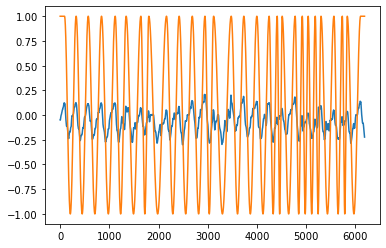

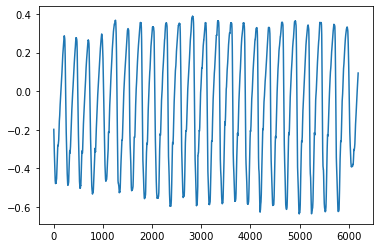

In [109]:
plt.plot(data_all[30]['leftJointPosition'])
plt.plot(data_all[30]['leftGaitPhaseX'])
plt.show()

plt.plot(data_all[30]['rightJointPosition'])
plt.show()

In [35]:
data_all = [data1, data2, data3, data4, data5]
columns_list = columns.transpose().values.tolist()[0]
data_list = []
for data in data_all:
    # drop the 32nd column which only contains NaN values
    data.dropna(axis=1, inplace=True)
    # rename the columns
    data.columns = columns_list
    # only keep the 10 sensors data columns
    data = data[sensors]
    data_list.append(data)

(10760, 10)


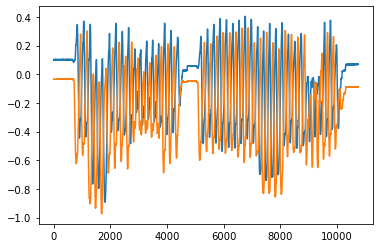

In [47]:
a = data_list[1].values
print(a.shape)
plt.plot(a[:,0])
plt.plot(a[:,1])
plt.show()
# print(np.shape(data1))